## Non-isothermal Recrystillization
The available measurements for recystillization of tungsten come from isothermal experiments. If the operating state of the fusion nuclear reactor equipment is steady, this condition is met perfectly. In the _transient_ case, and more generally speaking, when the temperature $T(t,\mathbf{x}): \{\mathcal{T} \times \mathcal{X} \} \to \mathbb{R}$  where $\mathcal{T}  \subseteq \mathbb{R}_+, \mathcal{X} \subseteq \mathbb{R}^3$ in the component is _not_ independent of time, we will need to extend the isothermal recrystillization model to accomodate this behavior. The notation $T(t,\mathbf{x})$ is replaced by $T(t)$ to simplify the equations, with the connotation being some temperature function at an unspecified point.

### RXMAT Assumptions
Durif _et al._ in [1] developed a model for anisothermal recrystillization from the JMAK model by considering two time periods: (1) during the incubation time and (2) after the incubation time. The time periods are broken into discrete intervals and the _fractional contribution_ of the recrystillization fraction is considered at each time interval is considered additively. That is, consider a partition of the time domain $\mathcal{T}$ into $n intervals$ 

1. Incubation time:

    $\rho_{inc}(T(t)) = \sum_{i = 1}^n \frac{t_{i + 1} - t_i}{t_{inc}(T_{i + \frac{1}{2}})}$ where $T_{i + \frac{1}{2}} \equiv \frac{T_{i+1} + T_{i}}{2} $

    From the riemann integral definition, clearly as $n \to \infty$ the above sum converges to:

    $\rho_{inc}(T(t)) = \int_{\mathcal{T}} \frac{d\tau}{t_{inc}(T(\tau))}$. 

    Provided reasonable assumptions about $T(t)$. When $\rho_{inc}(T(t)) \geq 1$ then the material is considered "fully incubated".

2. Phase Growth: Anisothermal JMAK equation 

    Consider the JMAK equation for isothermal recrystillization with no incubation time:

    $X(t,T) = 1 - \exp{(-b(T)^n t^n)}$

    which for a particular temperature reduces to:

    $X(t) = 1 - \exp{(-b^n t^n)}$

    The fundamental theorem of calculus provides that:

    $X(t) = \int_{\mathcal{T}} X^\prime(\tau) d\tau $  where $ X^\prime(t) = nb^n t^{n-1} \exp{(-b^n t^n)}$

    To facilitate development of an expression for aniosothermal recrystillization, seperate the time into two intervals, $\mathcal{T} = [0,t^\dagger] \cup (t^\dagger,t], \Delta t = t - t^\dagger$ and rewrite the above as:

    $X(t) = X(t^\dagger) + \int_{t^\dagger}^{t} X^\prime(\tau) d\tau$

    To first order, we can approximate the _anisothermal_ recrystillization $Y$ as:

    $Y(t) = Y(t^\dagger) + \int_{t^\dagger}^{t} X^\prime(\tau) d\tau$

    where we have assumed that $Y^\prime = X^\prime$. We assume further that recrystillization proceeds in only one direction, that is, $Y$ is an increasing function.

    $
    X^\prime(t,T) = n(t^\ddagger b(T(t))^{n-1} [b(T(t)) + b^\prime (T(t))] \exp{\{-b(T(t))^n (t^\ddagger)^n \}} \\ 
    t^\ddagger = t^* + \Delta t \\ 
    t^* = \frac{1}{b(T(t))} \ln{\left((1 - Y(t))^{-1} \right)}^{1/n} \\ 
    b^\prime(T(t)) = T^\prime(t) \frac{db}{dT} \\ 
    \frac{db}{dT} = -\frac{-A_1 B_1}{T(t)^2} \exp{\left(\frac{B_1}{T(t)} \right)}  \\ 
    $

    and as $\Delta t \to 0$

    $
    Y^\prime(t) =X^\prime(t,T) = F(t, Y(t)) = n(t^* b(T(t))^{n-1} [b(T(t)) + b^\prime (T(t))] \exp{\{-b(T(t))^n (t^*)^n \}} \\
    $
    
    which simplifies to:

    $
    Y^\prime(t) = F(t,Y(t)) = u(t) \ln{\left( \frac{1}{1 - Y(t)} \right)}^{\frac{n-1}{n}} (1 - Y(t)) \\ 
    u(t) = n [b(T(t)) + b^\prime (T(t))] 
    $

    this ODE doesn't appear to have an explicit solution (checked with sympy algebraic ode solver) so we'll just numerically integrate the expression:

    $
    Y^\prime(t) = F(t,Y(t)) \\
    $

[1] A. Durif, M. Richou, G. Kermouche, J. M. Bergheau, "Numerical study of the influence of tungsten recrystallization on the divertor component lifetime" (2021).


e:\ORNL Collaboration\System Design\ASME Code\modeling_tungsten\recrystallization\common_util.py:26: RuntimeWarning: invalid value encountered in power
  1.0 - np.exp(-b**n*(t - t_inc)**n)


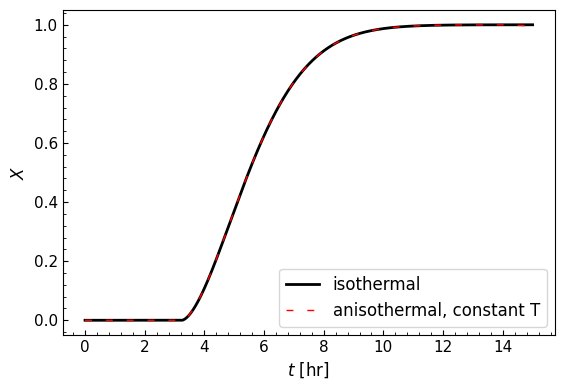

In [60]:
import numpy as np
from matplotlib import pyplot as plt
from common_util import LogLinearArrhenius,LogLinearArrheniusModelFunc, setup_axis_default
import math
import pickle
from typing import Callable
from scipy.integrate import quad
from scipy.optimize import bisect
from scipy.integrate import solve_ivp

def anisothermal_jmak_rx_integration_scipy(t: np.ndarray,
                                           T: Callable,
                                           Tdiff: Callable,
                                           jmak_model: LogLinearArrheniusModelFunc):
    

    a2 = jmak_model.ap2.params[0]
    A2 = math.exp(jmak_model.ap2.params[0])
    B2 = jmak_model.ap2.params[1]

    a1 = jmak_model.ap1.params[0]
    A1 = math.exp(jmak_model.ap1.params[0])
    B1 = jmak_model.ap1.params[1]
    n = jmak_model.n 

    def b(Temp: float):
        return math.exp(a1 + B1/Temp)
    
    def tinc(Temp: float):
        return math.exp(a2 + B2/Temp)
    
    def find_start_t():
        
        def rho_func(tt: float):
            return quad(lambda x: 1./tinc(T(x)),0,tt)[0] - 1.   
        
        return bisect(rho_func,t[0],t[-1])
    
    def integrate_func(tt: float, y: float):

        dbdT = -A1*B1/(T(tt)**2)*math.exp(B1/T(tt))
        db = dbdT*Tdiff(tt)

        u = n*(b(T(tt)) + db)
        y = min(y,1. - 1e-12)

        return u*np.log(1./(1. - y))**((n - 1)/n)*(1. -y)

    start_t = find_start_t()
    Y = np.zeros_like(t)
    index = t > start_t
    Y[~index] = 0

    Y[index] = solve_ivp(integrate_func,(t[0],t[-1]),np.array([1e-13]),
                         t_eval = (t[index] - start_t),method = 'DOP853',atol = 1e-20)['y'].squeeze()  

    return Y

t_eval = np.linspace(0,15*3600,100)

with open('.model/JMAK_alfonso_data_hr_robust weighted.pkl','rb') as f:
    jmak_model = pickle.load(f)

T_iso = 1250 + 273.15
Y = anisothermal_jmak_rx_integration_scipy(t_eval, lambda x: T_iso, lambda x: 0, jmak_model)

t_func = np.linspace(0.,15*3600,1000)
X = jmak_model.predict(np.array([t_func,T_iso*np.ones_like(t_func)]).T)

fig,ax = plt.subplots(figsize = (5.75,4.))
setup_axis_default(ax)

ax.set_xlabel('$t$ [hr]',fontsize = 12)
ax.set_ylabel('$X$',fontsize = 12)
ax.plot(t_func/3600,X,label = 'isothermal',lw = 2,color = 'k',ls = '-')
ax.plot(t_eval/3600,Y,label = 'anisothermal, constant T',lw = 1,color = 'red',ls = '--',dashes = (5,10))

ax.legend(fontsize = 12)
fig.tight_layout()
#fig.savefig('.temp_images/jmak_anisothermal_valid.svg')








### GLM Model

$t^*  = M - \frac{1}{B} \ln{\left(\left( \frac{1}{Y} \right)^\nu - 1 \right)}$

$X^\prime(t) = -\frac{1}{\nu}Z(t)^{-1/\nu - 1}Z^\prime(t)$

$Z(t) = 1 + \exp{-B(t - M)}$ 

$Z^\prime(t) = \left(B \left(M^\prime  -1 \right) + B^\prime (M - t) \right)\exp{-B(t - M)} = u^\dagger(t) ( Z(t) - 1)$

$X^\prime(t) = u(t) Z(t)^{-1/\nu - 1} ( Z(t) - 1)$ 

$u(t) = \frac{-1}{\nu} u^\dagger(t)$


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


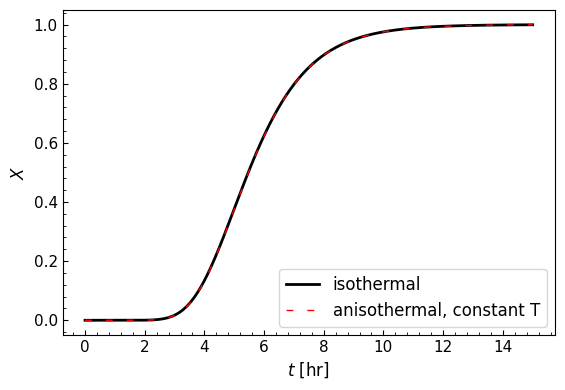

In [87]:

def anisothermal_glm_rx_integration(t: np.ndarray,
                                    T: Callable,
                                    Tdiff: Callable,
                                    glm_model: LogLinearArrheniusModelFunc):
    
    a2 = glm_model.ap2.params[0]
    A2 = math.exp(glm_model.ap2.params[0])
    B2 = glm_model.ap2.params[1]

    a1 = glm_model.ap1.params[0]
    A1 = math.exp(glm_model.ap1.params[0])
    B1 = glm_model.ap1.params[1]
    nu = glm_model.n 


    def B(Temp: float):
        return math.exp(a1 + B1/Temp)
    
    def M(Temp: float):
        return math.exp(a2 + B2/Temp)
    
    def integrate_func(tt: float, y: float,ymin: float):

        BB  = B(T(tt))
        MM = M(T(tt))
        dT = Tdiff(tt)
        TT = T(tt)

        y = max(1e-11,y) # to avoid numerical issues
        y = min(1. - 1e-11,y)

        arg = 1./(y**(-nu) - 1.)
        
        t_star = MM + 1./BB*np.log(arg)
        
        dBdT =  -A1*B1/(TT**2)*math.exp(B1/TT)
        dMdT = -A2*B2/(TT**2)*math.exp(B2/TT)
        dB = dBdT*dT
        dM = dMdT*dT

        delta_t = t_star - MM

        print(dB)
        Zp = (BB*(dM - 1.) + dB*delta_t)*np.exp(-delta_t*BB)
        Z = 1. + np.exp(-delta_t*BB)
        dY_ = -1./nu*Z**(-1./nu-1.)*Zp

        return dY_

    Y=  solve_ivp(integrate_func,(t[0],t[-1]),np.array([1e-20]),t_eval = t,
                       args = (1e-10,),first_step = 1e-15,method = 'DOP853',
                       atol = 1e-20)['y'].squeeze()


    return Y


t_eval = np.linspace(0,15*3600,1000)

with open('.model/Generalized Logistic_alfonso_data_hr_robust weighted.pkl','rb') as f:
    gl_model = pickle.load(f)

T_iso = 1250 + 273.15
Y = anisothermal_glm_rx_integration(t_eval, lambda x: T_iso, lambda x: 0, gl_model)

t_func = np.linspace(0,15*3600,1000)
X = gl_model.predict(np.array([t_func,T_iso*np.ones_like(t_func)]).T)

fig,ax = plt.subplots(figsize = (5.75,4.))
setup_axis_default(ax)

ax.set_xlabel('$t$ [hr]',fontsize = 12)
ax.set_ylabel('$X$',fontsize = 12)
ax.plot(t_func/3600,X,label = 'isothermal',lw = 2,color = 'k',ls = '-')
ax.plot(t_eval/3600,Y,label = 'anisothermal, constant T',lw = 1,color = 'red',ls = '--',dashes = (5,10))

ax.legend(fontsize = 12)
fig.tight_layout()
fig.savefig('.temp_images/glm_anisothermal_valid.svg')




### Temperature Visualizations

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


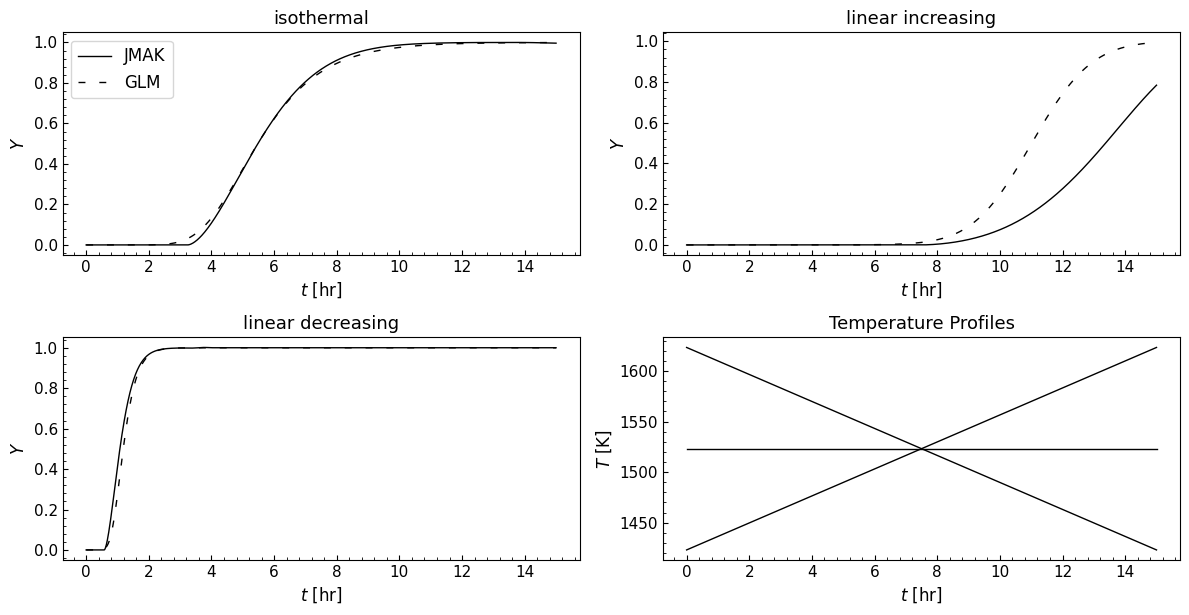

In [88]:
t_eval = np.linspace(0,15*3600,1000)
Tmin = 1150 + 273.15
Tmax = 1350 + 273.15
slope = (Tmax - Tmin)/(t_eval[-1] - t_eval[0])

temperature_funcs = [lambda x: 1250 + 273.15,
                     lambda x: 1150 + 273.15 + slope*x,
                     lambda x: 1350 + 273.15 - slope*x]

temperature_grads = [lambda x: 0,
                     lambda x: slope,
                     lambda x: -slope]

labels = ['isothermal','linear increasing','linear decreasing']
fig,axes = plt.subplots(figsize = (12,6.25),nrows = 2,ncols = 2)
for ax in axes.ravel():
    setup_axis_default(ax)

for tfunc,tgrad,ax,ax_title in zip(temperature_funcs,temperature_grads,axes.ravel(),labels):
    for integrator,model,ls,label in \
        zip([anisothermal_jmak_rx_integration_scipy,anisothermal_glm_rx_integration],[jmak_model,gl_model],['-','--'],['JMAK','GLM']):
        Y = integrator(t_eval, tfunc, tgrad, model)
        ax.plot(t_eval/3600,Y,label = label,lw = 1,color = 'k',ls = ls,dashes = (5,10) if ls == '--' else ())
    
    ax.set_xlabel('$t$ [hr]',fontsize = 12)
    ax.set_ylabel('$Y$',fontsize = 12)
    ax.set_title(ax_title,fontsize = 13)




axes[0,0].legend(fontsize = 12)

for tfunc in temperature_funcs:
    axes[-1,-1].plot(t_eval/3600,[tfunc(x) for x in t_eval],lw = 1,color = 'k')

axes[-1,-1].set_xlabel('$t$ [hr]',fontsize = 12)    
axes[-1,-1].set_ylabel('$T$ [K]',fontsize = 12)
axes[-1,-1].set_title('Temperature Profiles',fontsize = 13)

fig.tight_layout()
#fig.savefig('.temp_images/anisothermal_visualization.svg')

